In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.disable_eager_execution()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

Instructions for updating:
non-resource variables are not supported in the long term


# Dataset Creation

# Dataset
the distances between even numbers are 0

the distances between odd numbers are 0

the distances between a even and a odd number is 1


In [2]:
import random
count = 0
couples = []
TRAIN_SIZE = 2000
while(count<TRAIN_SIZE//3):
    r1 = random.randint(0, 99)
    r2=r1
    while(r2==r1 or r1%2!=r2%2):
        r2 = random.randint(0, 99)
    couples.append([r1, r2, 0])
    count+=1
while(count<TRAIN_SIZE):
    r1 = random.randint(0, 99)
    r2=r1
    while(r2==r1 or r1%2==r2%2):
        r2 = random.randint(0, 99)
    couples.append([r1, r2, 1])
    count+=1

In [3]:
import numpy as np
couples = np.array(couples)
np.random.shuffle(couples)
couples.shape

(2000, 3)

# Insert data into pandas

In [4]:

import pandas as pd
training_data_df = pd.DataFrame(couples, columns = ['obj1','obj2','dist'])

"""
X_training and Y_training can be obtained directly from couples numpy array  
Panda is used only to show how one can read data from csv file
"""
# If your train data is a csv file, load training data set from CSV file into panda dataframe
# training_data_df = pd.read_csv("sales_data_training.csv", dtype=float)

'\nX_training and Y_training can be obtained directly from couples numpy array  \nPanda is used only to show how one can read data from csv file\n'

In [5]:
# Pull out columns for X (data to train with) and Y (value to predict)
X_training = training_data_df.drop('dist', axis=1).values
Y_training = training_data_df[['dist']].values

In [6]:
# Reshaping the data
# X_training is: [[0,2], [1, 3], [4,5], .....]
# X1_training: [0, 1, 4, ....]
# X2_training: [2, 3, 5, ....]

X1_training = X_training.T[0]
X2_training = X_training.T[1]
print("X_training shape:",X1_training.shape)
print("Y_training shape:",Y_training.shape)

X_training shape: (2000,)
Y_training shape: (2000, 1)


In [7]:
TOTAL_OBJECTS = 100
EMBEDDING_DIM = 32
SCALE_FACTOR = 1

In [8]:
# Input Layer
with tf.variable_scope('input'):
    X1 = tf.placeholder(tf.int32, shape=(None,))
    X2 = tf.placeholder(tf.int32, shape=(None,))

In [9]:
# Embeddings Layer
with tf.variable_scope('embeddings_layer'):
    embeddings = tf.get_variable(name="embeddings", shape=[TOTAL_OBJECTS, EMBEDDING_DIM], initializer = tf.random_uniform_initializer(
    minval=0, maxval=1, seed=None, dtype=tf.dtypes.float32))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print(embeddings.eval())

[[0.33279347 0.43888867 0.97310185 ... 0.83700085 0.682415   0.02571166]
 [0.2278074  0.60964036 0.34233928 ... 0.99888456 0.39582586 0.3805138 ]
 [0.84850144 0.15930915 0.5591357  ... 0.38542616 0.6284666  0.56237006]
 ...
 [0.78975284 0.67512417 0.82297146 ... 0.8106326  0.29627633 0.6707978 ]
 [0.58619034 0.6601151  0.7019329  ... 0.7530787  0.9015378  0.35404646]
 [0.21936238 0.63927424 0.31476808 ... 0.6245241  0.8309356  0.07837987]]


In [11]:
# Output Layer
with tf.variable_scope('output'):
    # getting the embeddings of current and neighbor objects
    """
    # Select the embedding (obj_1) and context (obj_2) vectors for the current timestamp
    for example: if obj1= [0,1,2] and timeslot = [0,0,0]
    tf.stack([[0,1,2],[0,0,0], axis=1]) = tf.Tensor:shape=(3,2),
    numpy.array[[0,0],
                [1,0],
                [2,0]]
    col1=obj1, col2=timeslot
    embeddings = [[[e_o0_t0],[e_o0_t1],[e_o0_t2]],
                  [[e_o1_t0],[e_o1_t1],[e_o1_t2]],
                  [[e_o2_t0],[e_o2_t1],[e_o2_t2]]]
    tf.gather_nd(embeddings, tf.stack([obj1, timeslot], axis=1)) = [e_o0_t0, e_o1_t0, e_o2_t0]
    obj1_embedding = tf.gather_nd(embeddings, tf.stack([X1, Timestamp], axis=1))
    obj2_embedding = tf.gather_nd(embeddings, tf.stack([X2, Timestamp], axis=1))
    """
    obj1_embedding = tf.gather_nd(embeddings, tf.stack([X1], axis=1))
    obj2_embedding = tf.gather_nd(embeddings, tf.stack([X2], axis=1))
    prediction = tf.scalar_mul(SCALE_FACTOR,
                               tf.losses.cosine_distance(tf.nn.l2_normalize(obj1_embedding, axis=1),
                                                         tf.nn.l2_normalize(obj2_embedding, axis=1),
                                                         axis=1, reduction=tf.losses.Reduction.NONE))

In [12]:
# Section Two: Define the cost function of the neural network that will measure prediction accuracy during training
with tf.variable_scope('cost'):
    Y = tf.placeholder(tf.float32, shape=(None,1))
    cost = tf.losses.mean_squared_error(
        labels=tf.scalar_mul(SCALE_FACTOR, Y),
        predictions=prediction,
        reduction=tf.losses.Reduction.SUM)

In [13]:
learning_rate = 0.001

In [14]:
# Section Three: Define the optimizer function that will be run to optimize the neural network
with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [15]:
# Create a summary operation to log the progress of the network
with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    tf.summary.histogram('predicted_value', prediction)
    summary = tf.summary.merge_all()

In [16]:
RUN_NAME = "run 1 with 100 epoches"
training_epochs = 2000

In [17]:
# Initialize a session so that we can run TensorFlow operations
with tf.Session() as session:

    # Run the global variable initializer to initialize all variables and layers of the neural network
    session.run(tf.global_variables_initializer())
    
    # Create log file writers to record training progress.
    # We'll store training and testing log data separately.
    training_writer = tf.summary.FileWriter("./logs/{}/training".format(RUN_NAME), session.graph)
    #testing_writer = tf.summary.FileWriter("./logs/{}/testing".format(RUN_NAME), session.graph)
    
    # Run the optimizer over and over to train the network.
    # One epoch is one full run through the training data set.
    for epoch in range(training_epochs):

        # Feed in the training data and do one step of neural network training
        session.run(optimizer, feed_dict={X1: X1_training, X2: X2_training, Y: Y_training})
    
        
        # Every 5 training steps, log our progress
        if epoch % 20 == 0:
            # Get the current accuracy scores by running the "cost" operation on the training and test data sets
            training_cost, training_summary = session.run([cost, summary], feed_dict={X1: X1_training, X2: X2_training, Y: Y_training})
            #testing_cost, testing_summary = session.run([cost, summary], feed_dict={X: X_scaled_testing, Y: Y_scaled_testing})

            # Write the current training status to the log files (Which we can view with TensorBoard)
            training_writer.add_summary(training_summary, epoch)
            #testing_writer.add_summary(testing_summary, epoch)

            #Print the current training status to the screen
            print("Epoch: {} - Training Cost: {}".format(epoch, training_cost))

            
    # Training is now complete!
    print("Training is complete!")
    final_training_cost = session.run(cost, feed_dict={X1: X1_training, X2: X2_training, Y: Y_training})
    #final_testing_cost = session.run(cost, feed_dict={X: X_scaled_testing, Y: Y_scaled_testing})

    print("Final Training cost: {}".format(final_training_cost))
    #print("Final Testing cost: {}".format(final_testing_cost))

    # Close the logging writer, otherwise the tensorboard will fail to plot
    training_writer.close()
    #testing_writer.close()
    embeddings_val = embeddings.eval()

Epoch: 0 - Training Cost: 785.8309326171875
Epoch: 20 - Training Cost: 742.608154296875
Epoch: 40 - Training Cost: 700.3106079101562
Epoch: 60 - Training Cost: 659.5155639648438
Epoch: 80 - Training Cost: 620.587646484375
Epoch: 100 - Training Cost: 583.6615600585938
Epoch: 120 - Training Cost: 548.7095336914062
Epoch: 140 - Training Cost: 515.5428466796875
Epoch: 160 - Training Cost: 483.83929443359375
Epoch: 180 - Training Cost: 453.22271728515625
Epoch: 200 - Training Cost: 423.3299865722656
Epoch: 220 - Training Cost: 393.864013671875
Epoch: 240 - Training Cost: 364.63739013671875
Epoch: 260 - Training Cost: 335.5992431640625
Epoch: 280 - Training Cost: 306.8434143066406
Epoch: 300 - Training Cost: 278.593994140625
Epoch: 320 - Training Cost: 251.16964721679688
Epoch: 340 - Training Cost: 224.93370056152344
Epoch: 360 - Training Cost: 200.24102783203125
Epoch: 380 - Training Cost: 177.39125061035156
Epoch: 400 - Training Cost: 156.5958251953125
Epoch: 420 - Training Cost: 137.96206

In [18]:
# Shape
embeddings_val.shape

(100, 32)

# t-SNE plot

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def tsne_plot(embedding, fileName):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for i in range(len(embedding)):
        tokens.append(embedding[i])
        labels.append(i)
    
    tsne_model = TSNE(perplexity=25, n_components=2, init='pca', n_iter=2500, random_state=0)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 15)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(10, 4),
                     textcoords='offset points',
                     fontsize=13,
                     ha='right',
                     va='bottom')

    
    plt.savefig(fileName, dpi=300)
    plt.show()
    return x, y, labels

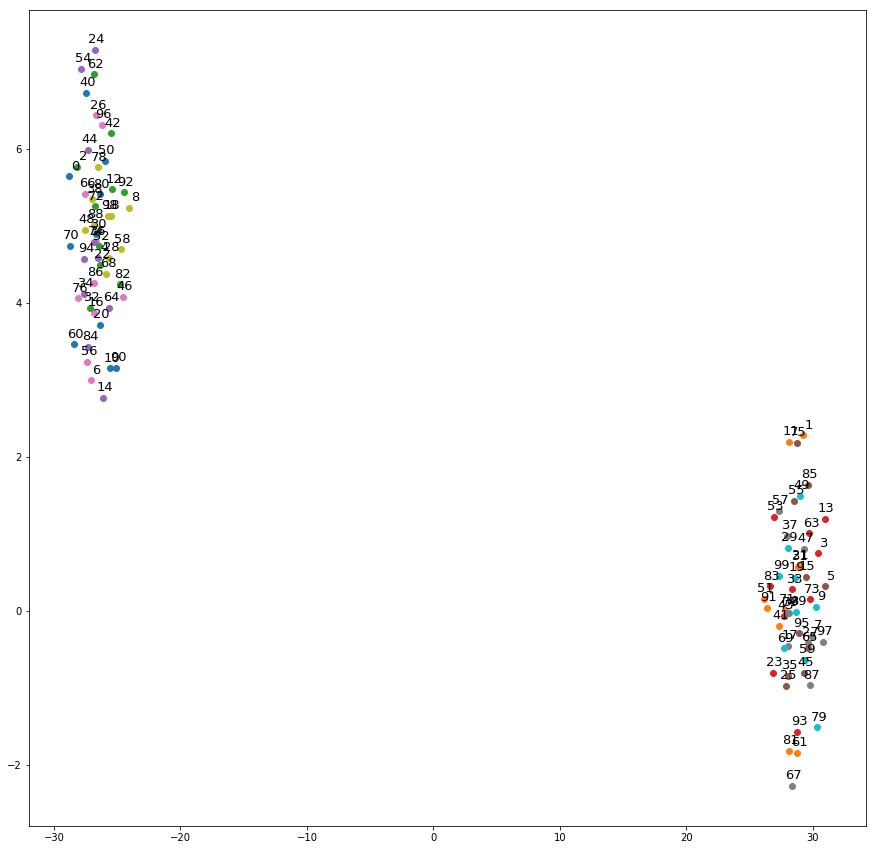

In [20]:
x, y, labels = tsne_plot(embeddings_val, "tsne_odd_even.png")